# Very Simple Models of Homeostasis 





(and a little bit about how to code agent/environment models more generally)



In [956]:
import numpy as np
import matplotlib.pyplot as plt
from collision import *
import gstools as gs

%load_ext autoreload
%autoreload 2
    
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


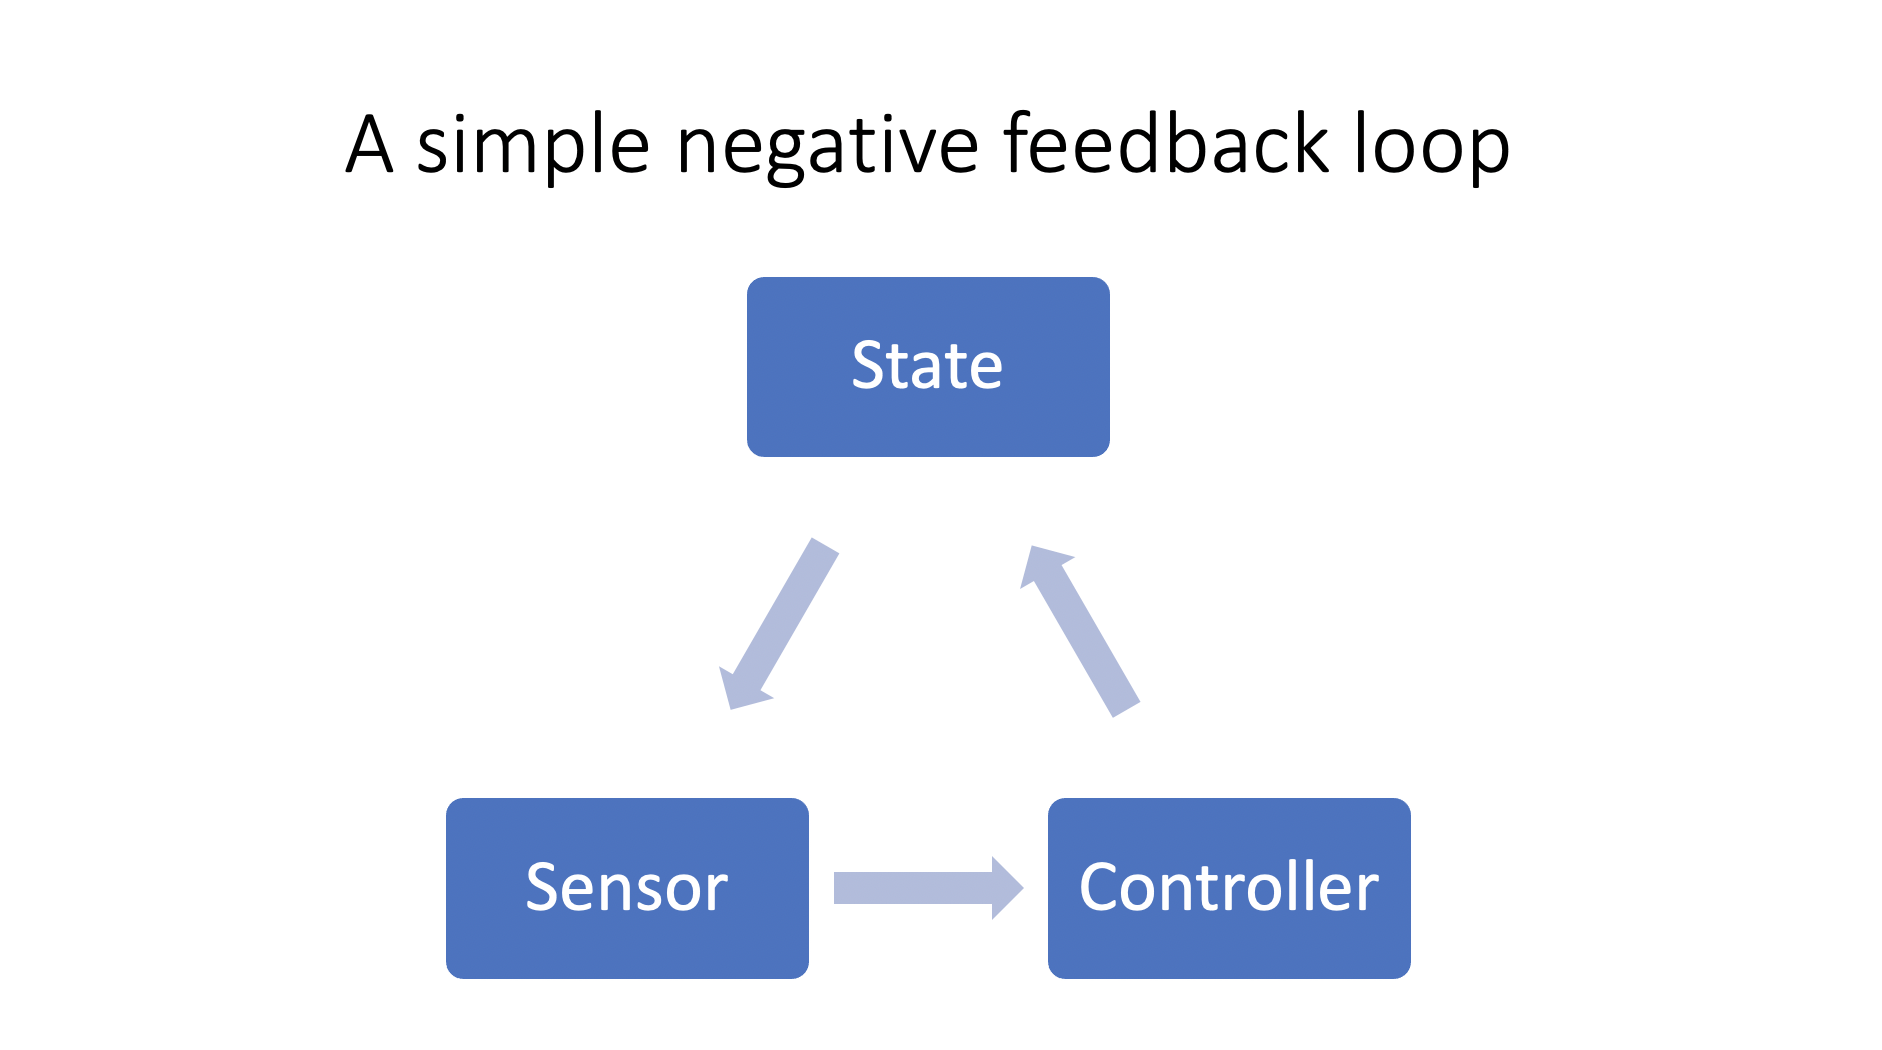



Even the simplest homeostatic system needs a few basic components. Take the example of temperature regulation:

> a state : $T{t}$
>
> homeostatic set point: $T^\circ$
>
> sensor: $T{t} - T^\circ$\
>
> controller: $T_{t+1}$

To put this together, we can describe the simplest form of homeostatic negative feedback as: 

> $T_{t+1} : T_{t} - (T_{t} - T^\circ) $

Lets do a very simple simulation to see how this works in practice.

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

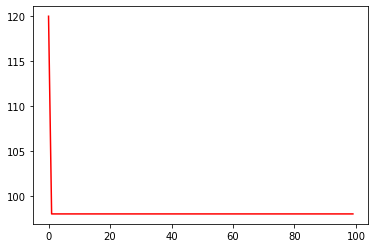

In [957]:
#lets do a simple simulation!

#set point of 98
To = 98
#starting temperature of 120
T_t = 120

#timesteps for the simulation
dt = 1
time = np.arange(0, 100, dt)

ts = []
for t in time:
    #log & step in time
    ts.append(T_t)
    
    #sensor
    s = (T_t-To)
    
    #controller 
    T_t = T_t - s
    
plt.plot(ts, 'r', label = "temperature")
sns.despine

physical systems can't simply change back all at once, we cant control exactly what our temperature is, rather we can just take action to move it back in the right direction. In math:

$$Tt = T_{t-1} - dt(Tt_{t-1}-To)$$

aka we want the gradient of temperature to be in the direction of the equilibrium temperature. Lets add that to our simulation, and notice the difference

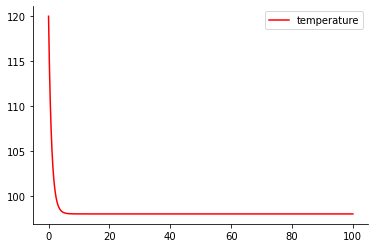

In [958]:
#now we take smaller steps
dt = .01

To = 98
T = 120

time = np.arange(0, 100, dt)

ts = []
for t in time:
    #log & step in time
    ts.append(T)
    
    #sensor
    s = (T-To)
    
    #controller 
    T = T - s*dt
    
    
plt.plot(time, ts, c = 'r', label = "temperature")
sns.despine()
plt.legend()

# what happens if something changes in the environment?


Next we add some external factors that can also influence our state -- the updated block diagram is:
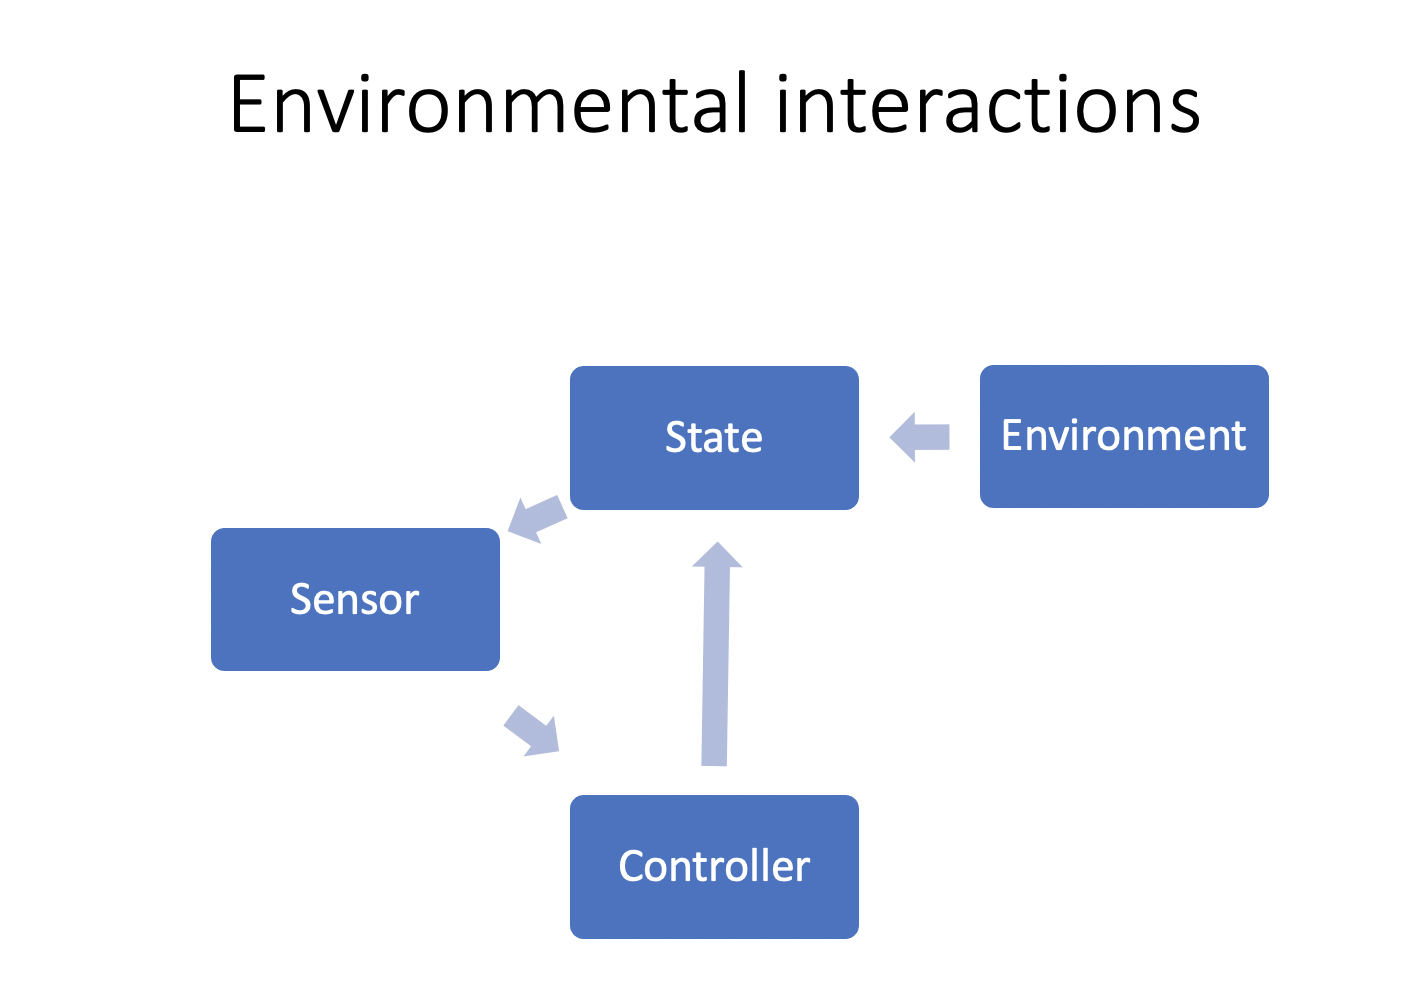

and add another equation

$$ Tt = T_{t-1} - dt(Tt_{t-1}-To) $$

$$ Tt = (T_{t-1} - T_{Env})*dt $$

Now the internal temperature takes a step in the direction of the environment! Lets add that to the simulation

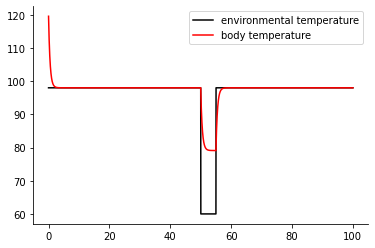

In [960]:

To = 98
T = 120

#environment is at our equilibrium point except for a small drop in the middle
#of the simulation
environment = np.zeros_like(time) + 98
environment[int(50/dt): int(55/dt)] = 60


ts = []
for i, t in enumerate(time):
    #environment
    T -= (T-environment[i])*dt
    
    #sensor 
    s = (T - To)
    
    #controller = 
    T -= s*dt

    #log
    ts.append(T)

    
plt.plot(time, environment, c ='k', label = 'environmental temperature')    
plt.plot(time, ts, c = 'r', label = 'body temperature')
plt.legend()
sns.despine()

# Two last bits of complexity before we move to a more real environment / situation! 

1) often the controller doesnt have perfect ability to move in the direction of the of the set point, rather it can turn on or off binary "coping" mechanisms -- like shivering or sweating, or turning the AC or heater on

2) often there is some wiggle room around the set point, an allowable range. 

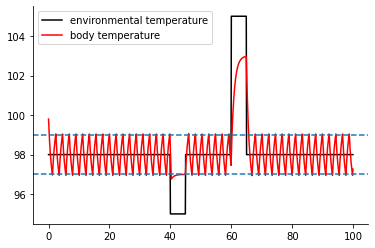

In [925]:
dt = .1
To = 98
T = 100
margin = 1
gain = 2
state = None

time = np.arange(0, 100, dt)
environment = 98 + np.zeros_like(time)
environment[int(40/dt): int(45/dt)] = 95
environment[int(60/dt): int(65/dt)] = 105


ts = []
for i, t in enumerate(time):
    #take a step
    #environment
    T -= (T - environment[i])*dt
    
    #self
    if state == 'heating':
        T += gain*dt
    if state == 'cooling':
        T -= gain*dt
    
    
    #sensor 
    s = (T - To)
    
    #controller 
    if s > margin:
        #too hot, we need to cool     
        state = 'cooling' #move temp colder
        
    if s < -1*margin:
        state = 'heating' #make temp hotter
        

    #log
    ts.append(T)

plt.plot(time, environment, c ='k', label = 'environmental temperature')    
plt.plot(time, ts, c = 'r', label = 'body temperature')
plt.axhline(To + margin, linestyle ='--')
plt.axhline(To- margin, linestyle = '--')
plt.legend()
sns.despine()

# a coding aside, object oriented simulations
helpful for this type of models to define
#1) the environment
#2) the agent

we will do this with python objects, which are totally useful for this circumstance. TODO: expand explanation on this section.

In [966]:
class simple_environment:
    def __init__(self, T_init, dt):
        self.T = T_init
        self.dt = dt
        self.log = []

        
    def advance(self, agent):
        self.log.append(self.T)
        #environment moves the agent forward one step
        agent.advance(self.dt)
        
        #environment interacts with the agent 
        self.interact(agent)
        
        #environment updates its own state variable
        self.update_temp()
        
    def interact(self, agent):
        agent.T -= (agent.T - self.T)*self.dt

        
    def update_temp(self):
        #lame environment always gets colder
        self.T -= .01

            
class simple_agent:
    def __init__(self, T_init, equil = 98, margin = 2):
        self.T = T_init
        self.equilibrium = equil
        self.margin = 2
        self.log = []
    
    def advance(self, dt):
        self.log.append(self.T)
        s = self.sense()
        
        if  s >= (self.equilibrium + self.margin):
            self.T -= 1
        if s <= (self.equilibrium - self.margin):
            self.T +=1 
            
    def sense(self):
        return self.T 

In [967]:
#now we run the simulation

dt =.01        
env = simple_environment(98, dt = .01)
a = simple_agent(120)

def simulate(time):
    for t in time:
        env.advance(a)
    
simulate(time)   

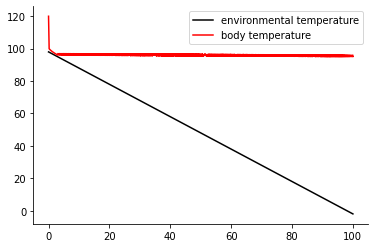

In [968]:
plt.plot(time, env.log, c ='k', label = 'environmental temperature')    
plt.plot(time, a.log, c = 'r', label = 'body temperature')
plt.legend()
sns.despine()

# one more piece of coding complexity: inheritance

say we want to change some small thing about our agent -- like add a fixed energy budget. We can do that by inheriting our agent class, and only overiding the methods we want to change! There is no need to change anything about the environment, it will still work exactly the same

In [970]:
class new_agent(simple_agent):
    def __init__(self, T_init = 100, energy_budget = 50):
        
        super(new_agent, self).__init__(T_init)
        
        self.energy_budget = energy_budget
        self.alive = True
        
    def advance(self, dt):
        self.log.append(self.T)
        s = self.sense()
        
        action = None
        if  s >= (self.equilibrium + self.margin):
            action = 'cool'
            
        if s <= (self.equilibrium - self.margin):
            action = 'heat'
            
        self.act(action)
        
        if self.energy_budget < 0:
            self.alive = False
           
            
    def act(self, action):
        if action == 'cool':
            self.T -= 1
            self.energy_budget -= 1
            
        if action == 'heat':
            self.T +=1 
            self.energy_budget -=1
    

In [973]:
#we change the simulate loop slightly so that if the agent dies the simulation ends

dt =.01        
env = simple_environment(98, dt = .01)
a = new_agent(120)

def simulate():
    while a.alive:
        env.advance(a)
    
simulate()   

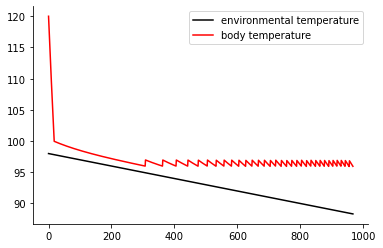

In [974]:
plt.plot( env.log, c ='k', label = 'environmental temperature')    
plt.plot( a.log, c = 'r', label = 'body temperature')
plt.legend()
sns.despine()

# a 2D temperature world


Now on to a more complicated environment. The basic idea is just a 2D generalization of what we've already done. There is a 2D temperature grid that an agent moves around in. Same as before the agent has an internal temperature, and it is influenced by the external temperature. Now the agent has the option of eating (using it's internal temperature store) to warm up, or moving to try to find a cooler spot. We will talk about more things the agents" can do as homework! 

<IPython.core.display.Javascript object>


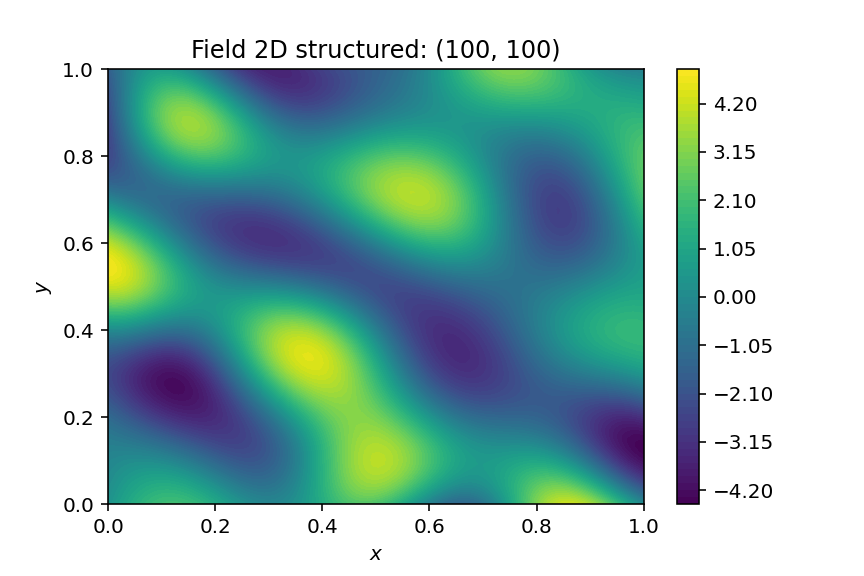

<AxesSubplot:title={'center':'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>

In [975]:
#notebook backend lets us have simulations more easily
%matplotlib notebook


# the grid -- this defines our world, now two dimensinoal!!
nd = 100 #how many dimensions?
x = np.linspace(0, 1, nd)
y = np.linspace(0, 1, nd)


#this is just a convenient way of getting out a heatmap -- TODO get rid of this code, added complexity isnt needed
st_model = gs.covmodel.JBessel(dim = 2, len_scale = .05, var = 5, angles = [0, 0])
srf = gs.SRF(st_model)
srf((x, y), mesh_type="structured");

srf.plot()

#so our environment is an x & y location, and a temperature at each place

In [1004]:
#inherits a simulation superclass that deals with animations etc.
#now lets define the code for the environment and the agent! 

class twoD_environment(Simulation):
    #this is our interaction! The environment changes temperature and motion of the particle
    def apply_forces(self, p):
            
            x_ind, y_ind = self.get_grid_inds(p)
            #print(p.v, p.vx, p.vy, x_ind, y_ind, p.x, p.y,self.srf.field[0][x_ind, y_ind])
            p.temperature = p.temperature + self.srf.field[x_ind, y_ind]*(self.dt) #add the velocity v
            
            #move faster in high temp regions
            if self.srf.field[x_ind, y_ind] > 0:
                p.v = p.v + .075*self.srf.field[x_ind, y_ind]*self.dt
            if self.srf.field[x_ind, y_ind] < 0:
                p.v = p.v + .01*self.srf.field[x_ind, y_ind]*self.dt
                
                
#particles have a position and velocity, a temperature, some energy, and other parameters for plotting
class newParticle(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x, y, dx, dy, radius, styles, food_store):
        
        super(newParticle, self).__init__(x, y, dx, dy, radius, styles)
        
        
        self.food_store = food_store
        self.temperature = 98; 
        self.set_point = 98 #homeostatic temp
        self.margin = .5
        
        self.temp_log = []
        self.food_log = []
    
    def monitor(self):
        return self.temperature - self.set_point
    
    def consume(self, dt):
    
        self.food_store -= 1;
        #the simulation draws the radius to show how much food is left   
        self.temperature += .1
         
    def move(self, dt, boost = 10):
    
        boost = np.random.uniform(-1, 1, size = 2)*boost
        self.v += boost 
        self.r += self.v * dt

        
    def exist(self, dt):
        #we slow down
        self.v = .95*self.v
        
        self.move(dt, boost = 0)
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)
        
        #this means we're dead!
        if self.food_store < 0:
            self.delete = True
        if self.temperature < 85 or self.temperature > 105:
            self.delete = True
            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        self.exist(dt)
        #check internal state
        d_temp = self.monitor()
        
        if d_temp < self.margin:
            self.consume(dt) 
        elif d_temp > self.margin:
            #nothing particle friend can do but move and hope life gets better
            self.move(dt, boost = .5)
            

<IPython.core.display.Javascript object>


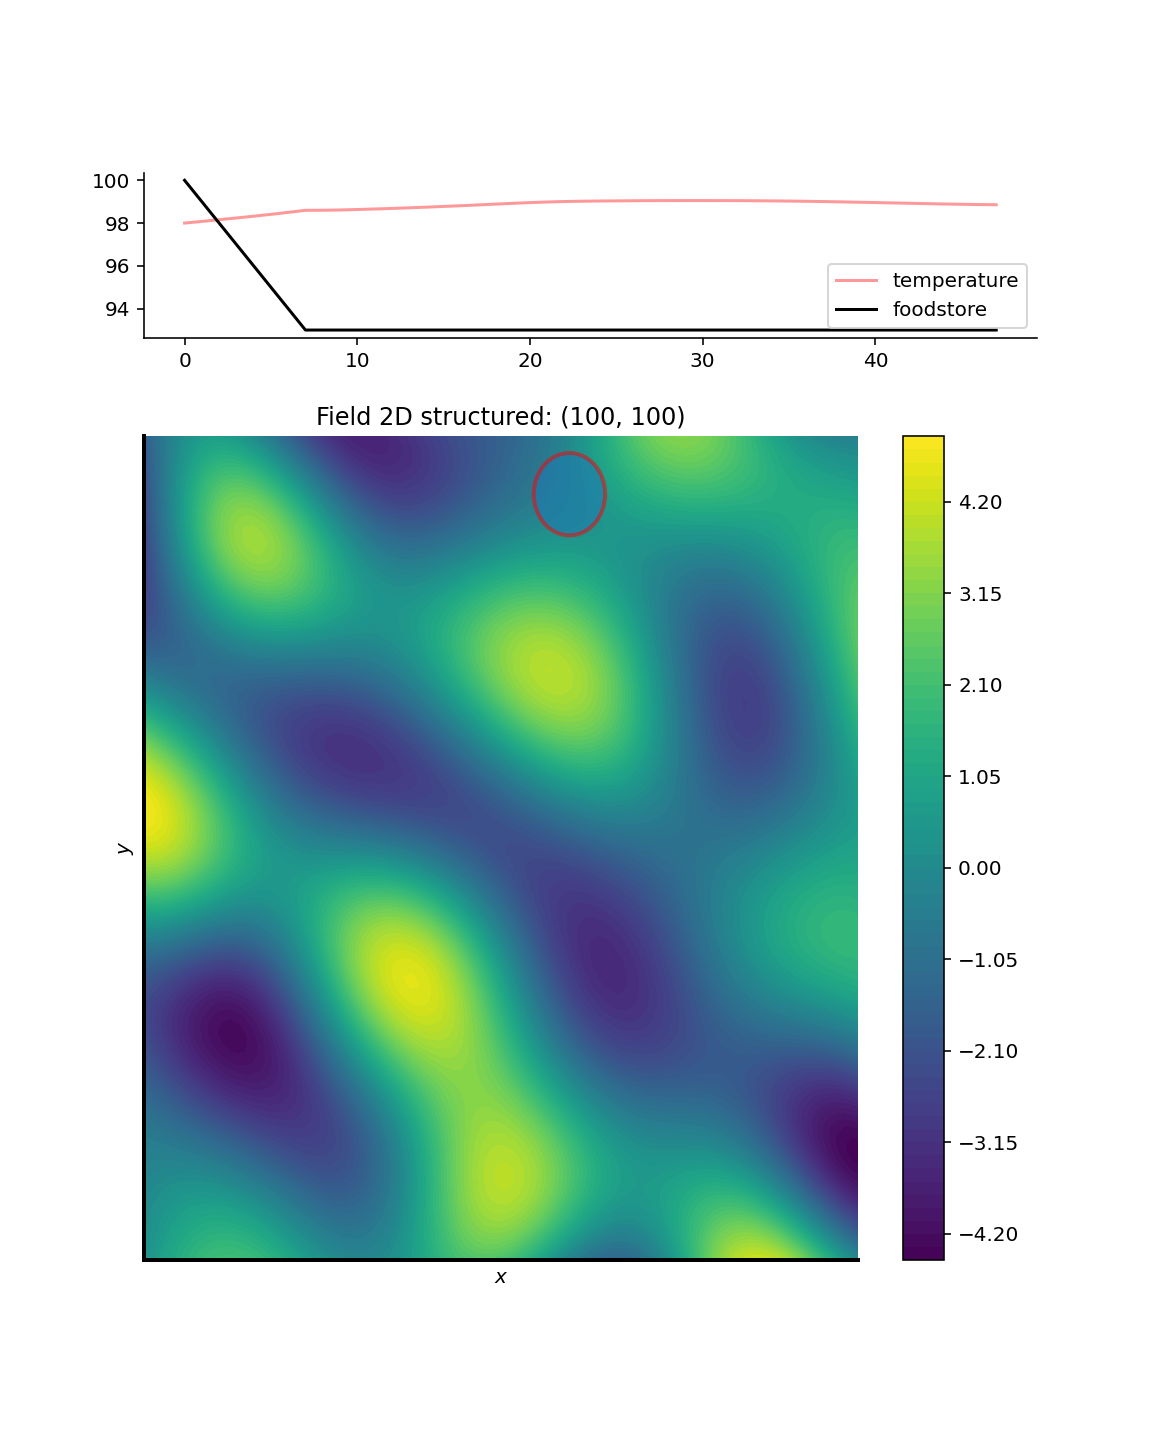

In [1005]:
nparticles = 0

styles = {'edgecolor': 'c', 'linewidth': 1, 'fill': 'c', 'alpha' : 1}


sim = twoD_environment(nparticles, [], styles, srf)
p = newParticle(.5, .5, 1.1, 1.1, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5}, food_store = 100)

sim.particles.insert(0, p)


anim = sim.do_animation(save=False)

# Despite being bigger, set the mass of the large particle to be the same
# as the small ones so it gains a bit of momentum in the collisions

In [893]:
#how long do we live on average?

In [989]:
life_times = []
for i in range(100):
    sim = twoD_environment(nparticles, [], styles, srf)
    p = newParticle(.5, .5, 1.1, 1.1, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5}, food_store = 100)
    #add our particle to the simulation
    
    sim.particles.insert(0, p)


    i = 0;
    while len(sim.particles) > 0: #the environment automatically removes the particle when it dies
        sim.advance()
        i+=1;
    life_times.append(i*sim.dt)
        

<IPython.core.display.Javascript object>


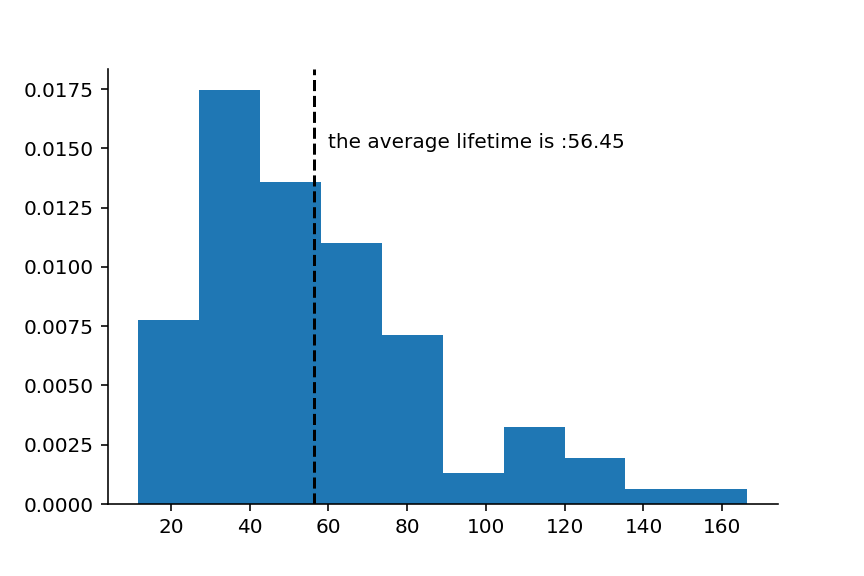

Text(60, 0.015, 'the average lifetime is :56.45')

In [1001]:
plt.hist(life_times, density = True)
sns.despine()
plt.axvline(np.mean(life_times), color = 'k', linestyle = '--')
plt.annotate("the average lifetime is :" + str(np.mean(life_times).round(2)), [60, .015])

In [1003]:
#homework: make the lifetime longer!!
#we inherit the newParticle class, and only override the move or advance function.
#Rules: you can't alter the particles temperature directly. 
#turn in your code in this cell, and a plot showing the lifetime of your particle! 

class hwParticle(newParticle):
    """A class representing a two-dimensional particle."""
        
    def move(self, dt, boost = 10):

    
        boost = np.random.uniform(-1, 1, size = 2)*boost
        self.v += boost 
        self.r += self.v * dt

            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        self.exist(dt)
        #check internal state
        d_temp = self.monitor()
        
        if d_temp < self.margin:
            self.consume(dt) 
        elif d_temp > self.margin:
            #nothing particle friend can do but move and hope life gets better
            self.move(dt, boost = .5)


In [1006]:
life_times = []
for i in range(100):
    sim = twoD_environment(nparticles, [], styles, srf)
    p = hwParticle(.5, .5, 1.1, 1.1, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5}, food_store = 100)
    p.margin = 5
    
    #add our particle to the simulation
    sim.particles.insert(0, p)


    i = 0;
    while len(sim.particles) > 0: #the environment automatically removes the particle when it dies
        sim.advance()
        i+=1;
    life_times.append(i*sim.dt)
        

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
plt.hist(life_times, density = True)
sns.despine()
plt.axvline(np.mean(life_times), color = 'k', linestyle = '--')
plt.annotate("the average lifetime is :" + str(np.mean(life_times).round(2)), [60, .015])

In [491]:
class CustomParticle(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x, y, dx, dy, radius, styles, food_store):
        
        super(CustomParticle, self).__init__(x, y, dx, dy, radius, styles)
        
        self.food_store = food_store
        self.temperature = 0; #homeostatic temp
        self.set_point = 0
        self.eat = False
        #exploration rate
        self.eps = .3
        self.temp_log = []
        self.food_log = []
        self.move_log = []
        #self.mass = .0001
        
    def overlaps(self, other):
    
        #here we overwrite the overlaps function, so our particle dudio knows when it overlapped with another particle
        overlap = np.hypot(*(self.r - other.r)) < (self.radius + other.radius )
        
        if overlap & self.eat:
            self.food_store += 200*other.radius;
            other.delete = True
            self.radius += .001 
            #self.eat = False
            #always eat
            return False
        else:
            return overlap

    
    def monitor(self):
        return self.temperature - self.set_point 
    
    def consume(self, dt):
    
        
        self.food_store -=1;
        self.radius += .001;
        self.temperature += .1
        
        if np.random.uniform() < self.eps:
            self.move(dt, boost = 2)
        else:
            self.move(dt, boost = 0)
            
 
            
             #should make an actual error
    
    def move(self, dt, boost = 2):
        
        self.food_store -= boost*1;
        self.radius -= boost*.0001
        self.temperature += boost*.01

        boost = np.random.uniform(-1, 1, size = 2)*boost
        
        self.v += self.v*boost 
        self.r += self.v * dt
        
        self.move_log.append(np.mean(self.v * dt))
        
    def exist(self):
       
        self.v -=.001*self.v
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)
        
        self.radius -= .0001
        self.temperature -= .01
        
        if self.food_store < 0:
            self.delete = True
        if self.temperature < -1 or self.temperature > 1:
            self.delete = True
            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        self.exist()
        #check internal state
        d_temp = self.monitor()
        
        if d_temp < 0.1:
            self.consume(dt) 
        elif d_temp > .1:
            self.move(dt, boost = 0)
        else:           
            self.move(dt, boost = .1)
        
        
        

In [492]:
p = CustomParticle(.25, .25, .2, .2, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5}, food_store = 100)
sim.particles.insert(0, p)

<IPython.core.display.Javascript object>


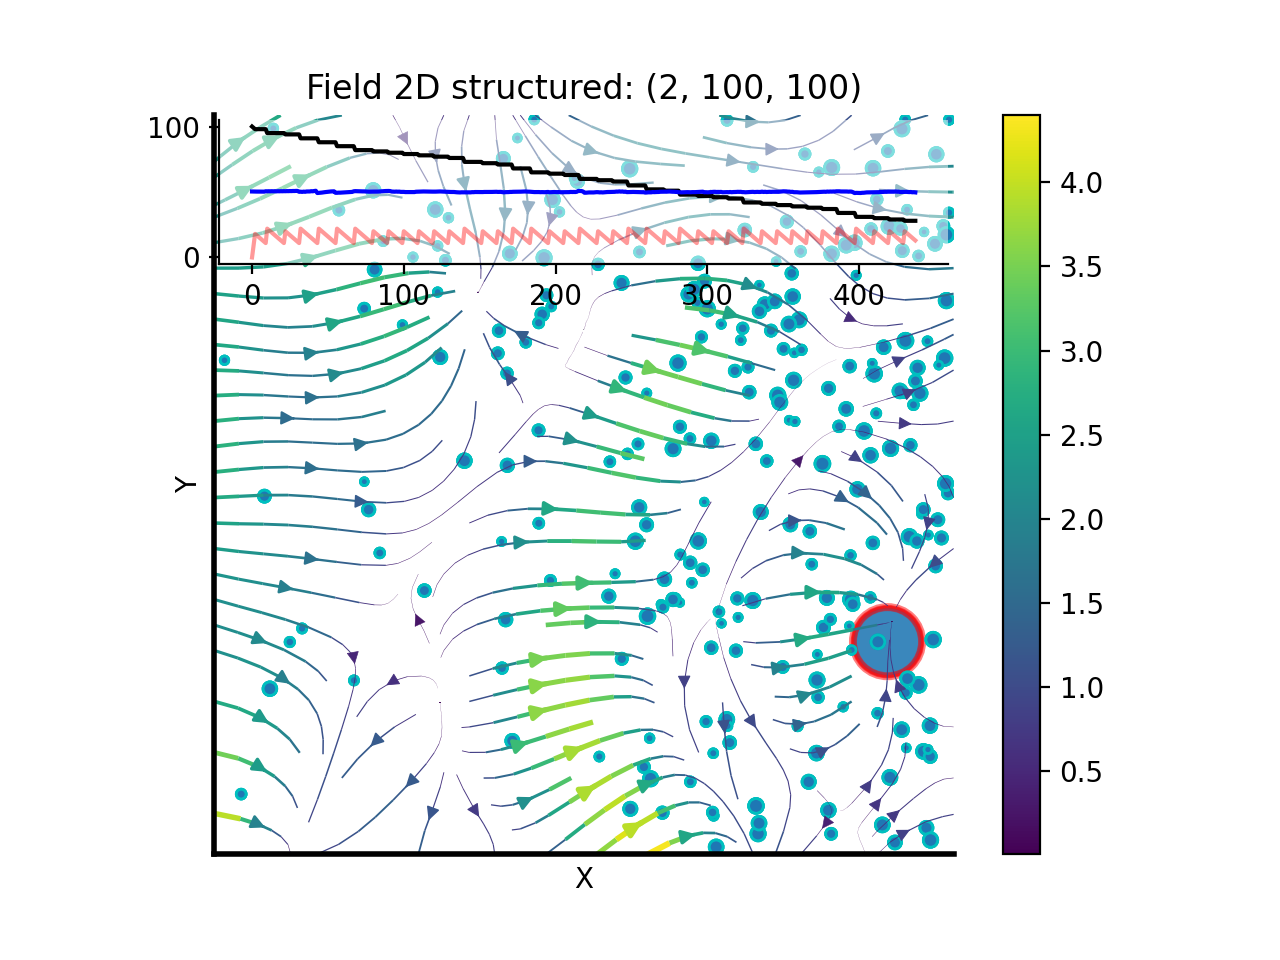

In [493]:
anim = sim.do_animation(save=False)


In [388]:
from matplotlib.patches import Circle

In [ ]:
small_particle_radius = 0.005
radii = np.random.random(nparticles)*small_particle_radius+0.005


In [ ]:
plt.subplot()